# Policy/Pi-Value/Q-Adverserial/A gradients (PQA)


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [36]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [40]:
import numpy as np
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [41]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    rewards = tf.placeholder(tf.float32, [None], name='rewards') # env rewards
    rewards2 = tf.placeholder(tf.float32, [None], name='rewards2') # actions logits rewards
    rewards3 = tf.placeholder(tf.float32, [None], name='rewards3') # actions labels rewards
    return states, actions, rewards, rewards2, rewards3

In [42]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [43]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [44]:
# def model_loss(action_size, hidden_size, # model init
#                states, actions, rewards, rewards2, rewards3): # model input for G & D 
#     # policy learning/gradient
#     actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
#     actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
#     g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
#                                                                        labels=actions_labels))        
    
#     # Q learning and Adverserial training
#     # Fake or generated or logits or prob
#     #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
#     actions_probs = tf.nn.softmax(actions_logits)
#     Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
#     rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
#     d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
#                                                                          labels=tf.reshape(rewards, shape=[-1, 1])))
#     d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
#                                                                           labels=tf.reshape(rewards2[1:], 
#                                                                                             shape=[-1, 1])))
#     #d_loss_fake = tf.reduce_mean(tf.square(Qs2_logits[:-1] - tf.reshape(rewards2[1:], shape=[-1, 1])))
    
#     # Real or env or onehot encoded or label
#     #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
#     Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
#     rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
#     d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
#                                                                           labels=tf.reshape(rewards, shape=[-1, 1])))
#     d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
#                                                                           labels=tf.reshape(rewards3[1:], 
#                                                                                             shape=[-1, 1])))
#     #d_loss_real += tf.reduce_mean(tf.square(Qs3_logits[:-1] - tf.reshape(rewards3[1:], shape=[-1, 1])))
    
#     # Reletavistic Adverserial training/learning (A-learning)
#     d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
#                                                                           labels=tf.zeros_like(tf.reshape(
#                                                                               rewards, shape=[-1, 1]))))
#     d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
#                                                                           labels=tf.zeros_like(
#                                                                               tf.reshape(rewards2[1:], shape=[-1, 1]))))
#     # d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
#     #                                                                       labels=tf.zeros_like(
#     #                                                                           tf.reshape(rewards, shape=[-1, 1]))))
#     # d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
#     #                                                                       labels=tf.zeros_like(
#     #                                                                           tf.reshape(rewards2[1:], shape=[-1, 1]))))
    
#     # Returning/outputing actions, sum of rewards, rewards, and loss
#     return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [45]:
def model_loss(action_size, hidden_size, # model init
               states, actions, rewards, rewards2, rewards3): # model input for G & D 
    # policy learning/gradient
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                       labels=actions_labels))        
    
    #actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    actions_probs = tf.nn.softmax(actions_logits)
    Qs2_logits = discriminator(actions=actions_probs, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    rewards2_logits = tf.nn.sigmoid(Qs2_logits) # total_rewards2
    #d_loss_fake = tf.reduce_mean(tf.square(Qs2_logits[:-1] - tf.reshape(rewards2[1:], shape=[-1, 1])))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                         labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_fake += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.reshape(rewards2[1:], 
                                                                                            shape=[-1, 1])))
    
    # Real or env or onehot encoded or label
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs3_logits = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rewards3_logits = tf.nn.sigmoid(Qs3_logits) # total_rewards3
    #d_loss_real += tf.reduce_mean(tf.square(Qs3_logits[:-1] - tf.reshape(rewards3[1:], shape=[-1, 1])))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits,
                                                                          labels=tf.reshape(rewards, shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs3_logits[:-1],
                                                                          labels=tf.reshape(rewards3[1:], 
                                                                                            shape=[-1, 1])))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits,
                                                                          labels=tf.zeros_like(tf.reshape(
                                                                              rewards, shape=[-1, 1]))))
    d_loss_real += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs2_logits[:-1],
                                                                          labels=tf.zeros_like(
                                                                              tf.reshape(rewards2[1:], shape=[-1, 1]))))
    
    # Returning/outputing actions, sum of rewards, rewards, and loss
    return actions_logits, rewards2_logits, rewards3_logits, g_loss, d_loss_fake, d_loss_real

In [46]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss_fake, d_loss_real, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss_fake: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param d_loss_real: Discriminator loss Tensor for reward prediction for env/onehot/labels action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_real, var_list=d_vars)
        gd_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_fake, var_list=g_vars)

    return g_opt, d_opt, gd_opt

In [47]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.rewards, self.rewards2, self.rewards3 = model_input(state_size=state_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.rewards2_logits, self.rewards3_logits, self.g_loss, self.d_loss_fake, self.d_loss_real = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init 
            actions=self.actions, states=self.states, # model input
            rewards=self.rewards, rewards2=self.rewards2, rewards3=self.rewards3) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.gd_opt = model_opt(g_loss=self.g_loss, 
                                                        d_loss_fake=self.d_loss_fake,
                                                        d_loss_real=self.d_loss_real,
                                                        learning_rate=learning_rate)

In [48]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [49]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

In [ ]:
# Now train with experiences
saver = tf.train.Saver()
# t_vars = tf.trainable_variables()
# g_vars = [var for var in t_vars if var.name.startswith('generator')]
# d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
# # saver = tf.train.Saver(var_list=d_vars)
# saver = tf.train.Saver(var_list=g_vars) # train D
# # saver = tf.train.Saver(var_list=t_vars)
# # Env reward, action logits reward, action labels/onehot reward
# rewards_list, rewards2_list, rewards3_list, gloss_list, dloss_list = [], [], [], [], []

# TF session for training
with tf.Session() as sess:
    
    # Rstoring/loading the trained/learned controller SA/SM
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-g.ckpt') 
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    train_episodes = 1000
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0 # reward env
        total_reward2 = 0 # reward action logits
        total_reward3 = 0 # reward action onehot/labels

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits, reward2, reward3 = sess.run([model.actions_logits, 
                                                        model.rewards2_logits, 
                                                        model.rewards3_logits],
                                                       feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                                  model.actions: np.array([action])})
                                                                  #model.actions: np.reshape(action, [-1])})
            #print(reward2[0, 0], reward3.reshape(-1))
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            #action *= 1-float(done)
            total_reward += reward # env
            total_reward2 += reward2[0, 0] #_action_logits
            total_reward3 += reward3[0, 0] #_actions_labels
            # state & action pair for policy learning: current policy/action
            # reward for adverserial/reward learning: current reward/value
            # reward2 and reward3 for value/Q learning: future rewards/value
            batch.append([state, action, reward, reward2[0, 0], reward3[0, 0]])
            state = next_state
            if done is True:
                break
                
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        rewards2 = np.array([each[3] for each in batch])
        rewards3 = np.array([each[4] for each in batch])
#         g_loss, _ = sess.run([model.g_loss, model.g_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions})
#         d_loss_fake, _ = sess.run([model.d_loss_fake, model.gd_opt], 
#                              feed_dict = {model.states: states,
#                                           model.actions: actions, 
#                                           model.rewards:rewards, 
#                                           model.rewards2:rewards2, 
#                                           model.rewards3:rewards3})
#         d_loss_real, _ = sess.run([model.d_loss_real, model.d_opt], 
#                                      feed_dict = {model.states: states,
#                                                   model.actions: actions, 
#                                                   model.rewards:rewards, 
#                                                   model.rewards2:rewards2, 
#                                                   model.rewards3:rewards3})
        g_loss, d_loss_fake, d_loss_real, _ = sess.run([model.g_loss, 
                                                        model.d_loss_fake, 
                                                        model.d_loss_real, 
                                                        model.d_opt], 
                                     feed_dict = {model.states: states,
                                                  model.actions: actions, 
                                                  model.rewards:rewards, 
                                                  model.rewards2:rewards2, 
                                                  model.rewards3:rewards3})
        print('Episode: {}'.format(ep),
              'total_reward: {}'.format(total_reward),
              'total_reward2: {:.4f}'.format(total_reward2),
              'total_reward3: {:.4f}'.format(total_reward3),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss_fake: {:.4f}'.format(d_loss_fake),
              'd_loss_real: {:.4f}'.format(d_loss_real))
#         rewards_list.append([ep, total_reward])
#         rewards2_list.append([ep, total_reward2])
#         rewards3_list.append([ep, total_reward3])
#         gloss_list.append([ep, g_loss])
#         dloss_list.append([ep, d_loss])
        
    # Save the trained/learned D using G/SM/SA
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-g-d.ckpt')
    #saver.save(sess, tf.train.latest_checkpoint('checkpoints'))

INFO:tensorflow:Restoring parameters from checkpoints/model-g.ckpt
Episode: 0 total_reward: 500.0 total_reward2: 236.2551 total_reward3: 236.7249 g_loss: 0.1814 d_loss_fake: 1.4414 d_loss_real: 2.7155
Episode: 1 total_reward: 500.0 total_reward2: 230.2093 total_reward3: 231.4682 g_loss: 0.1740 d_loss_fake: 1.4657 d_loss_real: 2.6936
Episode: 2 total_reward: 500.0 total_reward2: 224.0749 total_reward3: 226.0568 g_loss: 0.1810 d_loss_fake: 1.4905 d_loss_real: 2.6727
Episode: 3 total_reward: 500.0 total_reward2: 217.8334 total_reward3: 220.6304 g_loss: 0.1777 d_loss_fake: 1.5159 d_loss_real: 2.6530
Episode: 4 total_reward: 227.0 total_reward2: 98.4931 total_reward3: 98.9522 g_loss: 0.1551 d_loss_fake: 1.5196 d_loss_real: 2.6577
Episode: 5 total_reward: 500.0 total_reward2: 205.6192 total_reward3: 209.7630 g_loss: 0.1856 d_loss_fake: 1.5665 d_loss_real: 2.6189
Episode: 6 total_reward: 500.0 total_reward2: 201.4691 total_reward3: 205.1894 g_loss: 0.1802 d_loss_fake: 1.5838 d_loss_real: 2.61

Episode: 61 total_reward: 500.0 total_reward2: 157.7862 total_reward3: 216.7146 g_loss: 0.1821 d_loss_fake: 1.8139 d_loss_real: 2.4028
Episode: 62 total_reward: 500.0 total_reward2: 159.4734 total_reward3: 222.0498 g_loss: 0.1850 d_loss_fake: 1.8098 d_loss_real: 2.3956
Episode: 63 total_reward: 500.0 total_reward2: 161.3493 total_reward3: 222.2802 g_loss: 0.1704 d_loss_fake: 1.8005 d_loss_real: 2.4091
Episode: 64 total_reward: 500.0 total_reward2: 160.4241 total_reward3: 222.7163 g_loss: 0.1747 d_loss_fake: 1.8055 d_loss_real: 2.4022
Episode: 65 total_reward: 500.0 total_reward2: 161.9316 total_reward3: 230.8481 g_loss: 0.1871 d_loss_fake: 1.8076 d_loss_real: 2.3844
Episode: 66 total_reward: 500.0 total_reward2: 163.9560 total_reward3: 235.3588 g_loss: 0.1916 d_loss_fake: 1.8027 d_loss_real: 2.3809
Episode: 67 total_reward: 500.0 total_reward2: 163.2244 total_reward3: 234.0468 g_loss: 0.1809 d_loss_fake: 1.8039 d_loss_real: 2.3846
Episode: 68 total_reward: 500.0 total_reward2: 165.9768

Episode: 122 total_reward: 500.0 total_reward2: 145.5796 total_reward3: 370.3545 g_loss: 0.1744 d_loss_fake: 2.2678 d_loss_real: 2.0585
Episode: 123 total_reward: 500.0 total_reward2: 145.7507 total_reward3: 376.7351 g_loss: 0.1804 d_loss_fake: 2.2863 d_loss_real: 2.0178
Episode: 124 total_reward: 500.0 total_reward2: 151.7325 total_reward3: 386.2657 g_loss: 0.1806 d_loss_fake: 2.2577 d_loss_real: 1.9965
Episode: 125 total_reward: 500.0 total_reward2: 159.1743 total_reward3: 394.1077 g_loss: 0.1784 d_loss_fake: 2.2352 d_loss_real: 1.9932
Episode: 126 total_reward: 500.0 total_reward2: 172.4746 total_reward3: 401.6004 g_loss: 0.1725 d_loss_fake: 2.1824 d_loss_real: 2.0321
Episode: 127 total_reward: 500.0 total_reward2: 171.4920 total_reward3: 396.6313 g_loss: 0.1687 d_loss_fake: 2.1941 d_loss_real: 2.0690
Episode: 128 total_reward: 500.0 total_reward2: 165.7698 total_reward3: 406.9143 g_loss: 0.1793 d_loss_fake: 2.2631 d_loss_real: 1.9591
Episode: 129 total_reward: 500.0 total_reward2: 

Episode: 183 total_reward: 457.0 total_reward2: 132.6516 total_reward3: 374.0047 g_loss: 0.1284 d_loss_fake: 2.7737 d_loss_real: 2.1996
Episode: 184 total_reward: 500.0 total_reward2: 118.9630 total_reward3: 434.0585 g_loss: 0.1883 d_loss_fake: 3.2141 d_loss_real: 1.7295
Episode: 185 total_reward: 500.0 total_reward2: 167.2853 total_reward3: 431.6684 g_loss: 0.1381 d_loss_fake: 2.6944 d_loss_real: 2.1061
Episode: 186 total_reward: 500.0 total_reward2: 144.8763 total_reward3: 445.5555 g_loss: 0.1813 d_loss_fake: 3.0133 d_loss_real: 1.7404
Episode: 187 total_reward: 500.0 total_reward2: 152.0455 total_reward3: 446.8668 g_loss: 0.1742 d_loss_fake: 2.9853 d_loss_real: 1.7894
Episode: 188 total_reward: 500.0 total_reward2: 167.3426 total_reward3: 450.8451 g_loss: 0.1698 d_loss_fake: 2.8728 d_loss_real: 1.8511
Episode: 189 total_reward: 500.0 total_reward2: 167.7599 total_reward3: 451.8065 g_loss: 0.1652 d_loss_fake: 2.8979 d_loss_real: 1.8573
Episode: 190 total_reward: 500.0 total_reward2: 

Episode: 244 total_reward: 500.0 total_reward2: 127.8291 total_reward3: 446.4055 g_loss: 0.1796 d_loss_fake: 3.4963 d_loss_real: 1.6937
Episode: 245 total_reward: 108.0 total_reward2: 57.0382 total_reward3: 95.1519 g_loss: 0.0272 d_loss_fake: 1.5967 d_loss_real: 2.7677
Episode: 246 total_reward: 500.0 total_reward2: 137.6156 total_reward3: 448.0622 g_loss: 0.1742 d_loss_fake: 3.4859 d_loss_real: 1.7637
Episode: 247 total_reward: 500.0 total_reward2: 129.8871 total_reward3: 448.1447 g_loss: 0.1810 d_loss_fake: 3.5342 d_loss_real: 1.6758
Episode: 248 total_reward: 500.0 total_reward2: 128.6383 total_reward3: 449.1592 g_loss: 0.1843 d_loss_fake: 3.6942 d_loss_real: 1.6878
Episode: 249 total_reward: 500.0 total_reward2: 136.2286 total_reward3: 451.1386 g_loss: 0.1823 d_loss_fake: 3.4725 d_loss_real: 1.6768
Episode: 250 total_reward: 500.0 total_reward2: 141.9867 total_reward3: 452.5365 g_loss: 0.1776 d_loss_fake: 3.4322 d_loss_real: 1.6999
Episode: 251 total_reward: 500.0 total_reward2: 13

Episode: 305 total_reward: 500.0 total_reward2: 140.6863 total_reward3: 467.6014 g_loss: 0.1822 d_loss_fake: 3.9280 d_loss_real: 1.6227
Episode: 306 total_reward: 500.0 total_reward2: 148.4713 total_reward3: 469.0550 g_loss: 0.1904 d_loss_fake: 3.9459 d_loss_real: 1.6463
Episode: 307 total_reward: 500.0 total_reward2: 144.0699 total_reward3: 466.8577 g_loss: 0.1743 d_loss_fake: 3.8036 d_loss_real: 1.6668
Episode: 308 total_reward: 500.0 total_reward2: 132.7577 total_reward3: 465.9477 g_loss: 0.1821 d_loss_fake: 3.8456 d_loss_real: 1.5949
Episode: 309 total_reward: 500.0 total_reward2: 137.9574 total_reward3: 464.5337 g_loss: 0.1714 d_loss_fake: 3.7460 d_loss_real: 1.6853
Episode: 310 total_reward: 500.0 total_reward2: 125.6393 total_reward3: 465.1033 g_loss: 0.1961 d_loss_fake: 4.0390 d_loss_real: 1.5695
Episode: 311 total_reward: 500.0 total_reward2: 119.2527 total_reward3: 463.0318 g_loss: 0.1857 d_loss_fake: 4.0192 d_loss_real: 1.6081
Episode: 312 total_reward: 500.0 total_reward2: 

Episode: 366 total_reward: 500.0 total_reward2: 105.3686 total_reward3: 452.8986 g_loss: 0.1851 d_loss_fake: 4.3311 d_loss_real: 1.6604
Episode: 367 total_reward: 500.0 total_reward2: 133.3247 total_reward3: 456.6142 g_loss: 0.1599 d_loss_fake: 3.8435 d_loss_real: 1.8085
Episode: 368 total_reward: 334.0 total_reward2: 155.7665 total_reward3: 310.3651 g_loss: 0.1044 d_loss_fake: 3.0641 d_loss_real: 2.3297
Episode: 369 total_reward: 500.0 total_reward2: 113.1426 total_reward3: 457.6944 g_loss: 0.1816 d_loss_fake: 4.2823 d_loss_real: 1.6095
Episode: 370 total_reward: 500.0 total_reward2: 118.5805 total_reward3: 460.7681 g_loss: 0.1837 d_loss_fake: 4.4279 d_loss_real: 1.6068
Episode: 371 total_reward: 500.0 total_reward2: 119.4322 total_reward3: 459.1843 g_loss: 0.1793 d_loss_fake: 4.3348 d_loss_real: 1.6097
Episode: 372 total_reward: 500.0 total_reward2: 132.0300 total_reward3: 462.5501 g_loss: 0.1740 d_loss_fake: 4.3470 d_loss_real: 1.6520
Episode: 373 total_reward: 500.0 total_reward2: 

Episode: 427 total_reward: 500.0 total_reward2: 102.6688 total_reward3: 463.1879 g_loss: 0.1829 d_loss_fake: 4.7952 d_loss_real: 1.5923
Episode: 428 total_reward: 500.0 total_reward2: 114.5791 total_reward3: 465.4112 g_loss: 0.1800 d_loss_fake: 4.6784 d_loss_real: 1.6560
Episode: 429 total_reward: 100.0 total_reward2: 51.4012 total_reward3: 91.4905 g_loss: 0.0279 d_loss_fake: 1.7209 d_loss_real: 2.6724
Episode: 430 total_reward: 500.0 total_reward2: 123.0557 total_reward3: 468.1528 g_loss: 0.1764 d_loss_fake: 4.6050 d_loss_real: 1.5921
Episode: 431 total_reward: 500.0 total_reward2: 145.6017 total_reward3: 470.8142 g_loss: 0.1766 d_loss_fake: 4.8808 d_loss_real: 1.7294
Episode: 432 total_reward: 449.0 total_reward2: 167.0460 total_reward3: 415.5015 g_loss: 0.1276 d_loss_fake: 3.8557 d_loss_real: 2.1000
Episode: 433 total_reward: 500.0 total_reward2: 127.1912 total_reward3: 469.0011 g_loss: 0.1796 d_loss_fake: 4.5203 d_loss_real: 1.5797
Episode: 434 total_reward: 500.0 total_reward2: 12

Episode: 488 total_reward: 500.0 total_reward2: 129.9174 total_reward3: 476.3522 g_loss: 0.1882 d_loss_fake: 5.2974 d_loss_real: 1.5338
Episode: 489 total_reward: 500.0 total_reward2: 132.9168 total_reward3: 476.1627 g_loss: 0.1831 d_loss_fake: 5.1745 d_loss_real: 1.5879
Episode: 490 total_reward: 500.0 total_reward2: 147.7017 total_reward3: 475.2157 g_loss: 0.1776 d_loss_fake: 5.2204 d_loss_real: 1.7115
Episode: 491 total_reward: 102.0 total_reward2: 56.5174 total_reward3: 95.8314 g_loss: 0.0301 d_loss_fake: 1.7496 d_loss_real: 2.7422
Episode: 492 total_reward: 500.0 total_reward2: 120.6449 total_reward3: 472.0754 g_loss: 0.1773 d_loss_fake: 4.9129 d_loss_real: 1.6203
Episode: 493 total_reward: 500.0 total_reward2: 105.5467 total_reward3: 467.9626 g_loss: 0.1782 d_loss_fake: 4.9270 d_loss_real: 1.5872
Episode: 494 total_reward: 500.0 total_reward2: 153.1313 total_reward3: 470.9727 g_loss: 0.1550 d_loss_fake: 4.6508 d_loss_real: 1.8706
Episode: 495 total_reward: 241.0 total_reward2: 63

Episode: 549 total_reward: 500.0 total_reward2: 127.8117 total_reward3: 470.0626 g_loss: 0.1767 d_loss_fake: 5.0174 d_loss_real: 1.5762
Episode: 550 total_reward: 500.0 total_reward2: 118.4910 total_reward3: 469.4855 g_loss: 0.1813 d_loss_fake: 5.2077 d_loss_real: 1.5347
Episode: 551 total_reward: 500.0 total_reward2: 124.2376 total_reward3: 471.0707 g_loss: 0.1810 d_loss_fake: 5.2960 d_loss_real: 1.5510
Episode: 552 total_reward: 500.0 total_reward2: 127.3850 total_reward3: 473.2046 g_loss: 0.1893 d_loss_fake: 5.4397 d_loss_real: 1.5156
Episode: 553 total_reward: 500.0 total_reward2: 119.7562 total_reward3: 474.2497 g_loss: 0.1928 d_loss_fake: 5.6890 d_loss_real: 1.5067
Episode: 554 total_reward: 500.0 total_reward2: 135.3422 total_reward3: 475.9907 g_loss: 0.1910 d_loss_fake: 5.4681 d_loss_real: 1.5182
Episode: 555 total_reward: 184.0 total_reward2: 82.3965 total_reward3: 175.4095 g_loss: 0.1139 d_loss_fake: 3.5106 d_loss_real: 2.1415
Episode: 556 total_reward: 500.0 total_reward2: 1

Episode: 610 total_reward: 500.0 total_reward2: 112.3722 total_reward3: 473.9205 g_loss: 0.1811 d_loss_fake: 5.4826 d_loss_real: 1.5216
Episode: 611 total_reward: 500.0 total_reward2: 101.3140 total_reward3: 472.5526 g_loss: 0.1855 d_loss_fake: 5.5291 d_loss_real: 1.5581
Episode: 612 total_reward: 500.0 total_reward2: 118.5029 total_reward3: 472.4110 g_loss: 0.1822 d_loss_fake: 5.4842 d_loss_real: 1.6163
Episode: 613 total_reward: 500.0 total_reward2: 103.5591 total_reward3: 471.6269 g_loss: 0.1811 d_loss_fake: 5.4448 d_loss_real: 1.5426
Episode: 614 total_reward: 500.0 total_reward2: 124.4627 total_reward3: 473.9428 g_loss: 0.1694 d_loss_fake: 5.2088 d_loss_real: 1.6452
Episode: 615 total_reward: 500.0 total_reward2: 142.1633 total_reward3: 477.1797 g_loss: 0.1660 d_loss_fake: 5.1096 d_loss_real: 1.7045
Episode: 616 total_reward: 500.0 total_reward2: 125.2680 total_reward3: 480.1760 g_loss: 0.1896 d_loss_fake: 5.9480 d_loss_real: 1.5155
Episode: 617 total_reward: 500.0 total_reward2: 

Episode: 672 total_reward: 500.0 total_reward2: 114.1640 total_reward3: 464.9334 g_loss: 0.1651 d_loss_fake: 5.1226 d_loss_real: 1.7733
Episode: 673 total_reward: 240.0 total_reward2: 74.3857 total_reward3: 223.4402 g_loss: 0.1610 d_loss_fake: 4.6927 d_loss_real: 1.8818
Episode: 674 total_reward: 500.0 total_reward2: 93.8655 total_reward3: 465.2970 g_loss: 0.1809 d_loss_fake: 5.6589 d_loss_real: 1.5883
Episode: 675 total_reward: 500.0 total_reward2: 104.8543 total_reward3: 468.1450 g_loss: 0.1810 d_loss_fake: 5.6724 d_loss_real: 1.5477
Episode: 676 total_reward: 500.0 total_reward2: 120.0296 total_reward3: 473.0283 g_loss: 0.1767 d_loss_fake: 5.7392 d_loss_real: 1.5595
Episode: 677 total_reward: 500.0 total_reward2: 139.6386 total_reward3: 476.6531 g_loss: 0.1755 d_loss_fake: 5.3903 d_loss_real: 1.5674
Episode: 678 total_reward: 85.0 total_reward2: 50.4264 total_reward3: 80.9120 g_loss: 0.0337 d_loss_fake: 1.7083 d_loss_real: 2.7686
Episode: 679 total_reward: 500.0 total_reward2: 168.0

Episode: 733 total_reward: 500.0 total_reward2: 136.5575 total_reward3: 479.5737 g_loss: 0.1835 d_loss_fake: 5.9808 d_loss_real: 1.5335
Episode: 734 total_reward: 500.0 total_reward2: 132.8529 total_reward3: 479.2501 g_loss: 0.1817 d_loss_fake: 6.0911 d_loss_real: 1.5175
Episode: 735 total_reward: 500.0 total_reward2: 135.4584 total_reward3: 478.1957 g_loss: 0.1788 d_loss_fake: 6.0174 d_loss_real: 1.5109
Episode: 736 total_reward: 500.0 total_reward2: 133.6156 total_reward3: 477.9125 g_loss: 0.1813 d_loss_fake: 5.8396 d_loss_real: 1.5001
Episode: 737 total_reward: 500.0 total_reward2: 139.7705 total_reward3: 479.0538 g_loss: 0.1794 d_loss_fake: 6.0752 d_loss_real: 1.6101
Episode: 738 total_reward: 500.0 total_reward2: 126.9232 total_reward3: 478.4226 g_loss: 0.1862 d_loss_fake: 6.0601 d_loss_real: 1.5217
Episode: 739 total_reward: 500.0 total_reward2: 136.3031 total_reward3: 477.2534 g_loss: 0.1764 d_loss_fake: 5.6542 d_loss_real: 1.5738
Episode: 740 total_reward: 126.0 total_reward2: 

Episode: 794 total_reward: 500.0 total_reward2: 129.5817 total_reward3: 472.9982 g_loss: 0.1634 d_loss_fake: 5.6467 d_loss_real: 1.6827
Episode: 795 total_reward: 500.0 total_reward2: 122.6222 total_reward3: 475.5928 g_loss: 0.1808 d_loss_fake: 6.0791 d_loss_real: 1.5711
Episode: 796 total_reward: 244.0 total_reward2: 76.8092 total_reward3: 230.3762 g_loss: 0.1673 d_loss_fake: 5.1597 d_loss_real: 1.8277
Episode: 797 total_reward: 500.0 total_reward2: 140.6588 total_reward3: 479.7991 g_loss: 0.1819 d_loss_fake: 6.2941 d_loss_real: 1.5870
Episode: 798 total_reward: 324.0 total_reward2: 134.4084 total_reward3: 309.4584 g_loss: 0.1435 d_loss_fake: 4.4982 d_loss_real: 2.1474
Episode: 799 total_reward: 500.0 total_reward2: 135.0796 total_reward3: 480.8519 g_loss: 0.1897 d_loss_fake: 6.4578 d_loss_real: 1.5096
Episode: 800 total_reward: 500.0 total_reward2: 151.5846 total_reward3: 477.8513 g_loss: 0.1656 d_loss_fake: 5.4638 d_loss_real: 1.6905
Episode: 801 total_reward: 366.0 total_reward2: 1

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total env rewards')

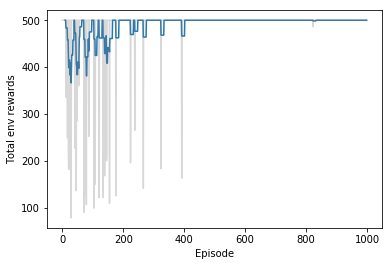

In [75]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total env rewards')

Text(0,0.5,'Total actions logits rewards')

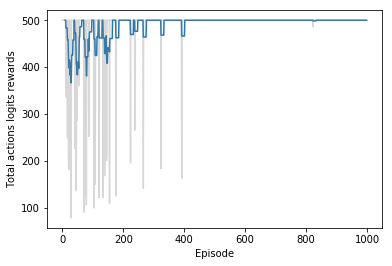

In [76]:
eps, arr = np.array(rewards2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions logits rewards')

Text(0,0.5,'Total actions labels/onehot rewards')

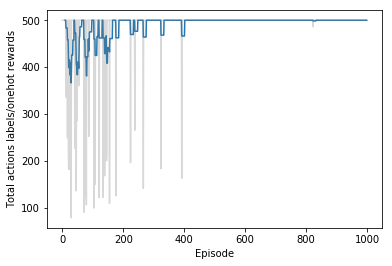

In [77]:
eps, arr = np.array(rewards3_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total actions labels/onehot rewards')

Text(0,0.5,'Gloss')

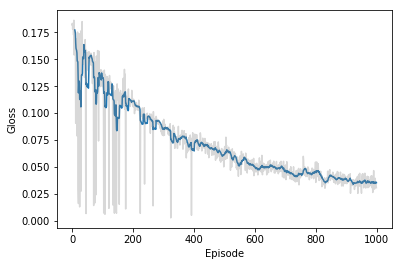

In [78]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Gloss')

Text(0,0.5,'Dloss')

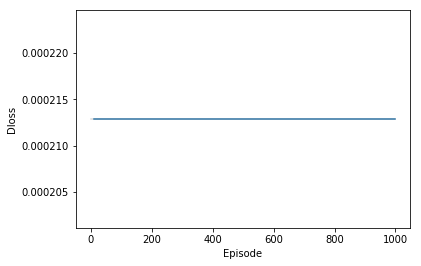

In [79]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Dloss')